# **Mental Health Disorder Prediction With Handwriting**

### **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### **2. Preprocess & Extract Features**

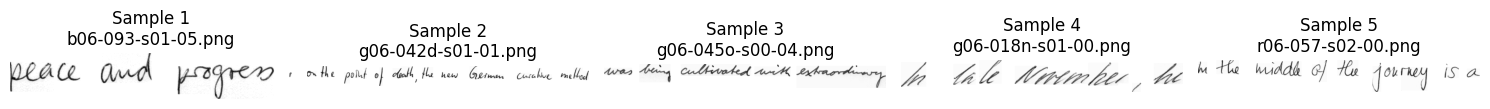

In [115]:
# Display Sample Images
data_path = './dataset/'
img_files = [f for f in os.listdir(data_path) if f.endswith('.png')]

# Select 5 random samples
sample_files = np.random.choice(img_files, 5, replace=False)

# Display sample images
plt.figure(figsize=(15, 3))
for idx, filename in enumerate(sample_files, 1):
    img_path = os.path.join(data_path, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(1, 5, idx)
    plt.imshow(img, cmap='gray')
    plt.title(f'Sample {idx}\n{filename}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [116]:
# Print basic dataset info
print("\nDataset Information:")
print(f"Total images: {len(img_files)}")
sample_img = cv2.imread(os.path.join(data_path, img_files[0]), cv2.IMREAD_GRAYSCALE)
print(f"Image dimensions: {sample_img.shape}")


Dataset Information:
Total images: 4899
Image dimensions: (89, 1661)


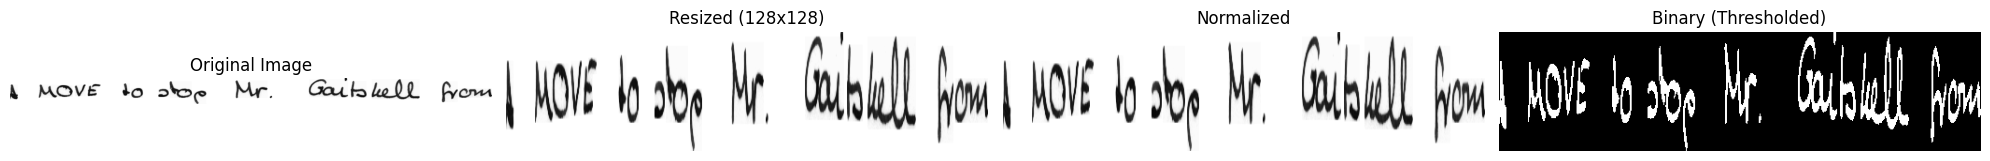

In [124]:
# Show Preprocessing Steps for One Sample Image
# Take first image as example
sample_path = os.path.join(data_path, img_files[0])
original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

# Preprocess image
resized = cv2.resize(original, (516, 128))
normalized = resized / 255.0
_, binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Display preprocessing steps
plt.figure(figsize=(20, 4))

# Original
plt.subplot(1, 4, 1)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Resized
plt.subplot(1, 4, 2)
plt.imshow(resized, cmap='gray')
plt.title('Resized (128x128)')
plt.axis('off')

# Normalized
plt.subplot(1, 4, 3)
plt.imshow(normalized, cmap='gray')
plt.title('Normalized')
plt.axis('off')

# Binary
plt.subplot(1, 4, 4)
plt.imshow(binary, cmap='gray')
plt.title('Binary (Thresholded)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Improved Feature Extraction and Labeling
def extract_handwriting_features(img):
    """Extract more robust handwriting features"""
    features = {}
    
    # 1. Calculate baseline angle
    # Use Hough transform to detect lines
    edges = cv2.Canny(img, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
    if lines is not None:
        angles = [line[0][1] for line in lines]
        features['baseline_angle'] = np.std(angles)
    else:
        features['baseline_angle'] = 0
    
    # 2. Calculate stroke density
    binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    features['stroke_density'] = np.sum(binary > 0) / binary.size
    
    # 3. Calculate size variations
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        sizes = [cv2.contourArea(cnt) for cnt in contours]
        features['size_variation'] = np.std(sizes) if sizes else 0
    else:
        features['size_variation'] = 0
    
    # 4. Calculate space regularity
    horizontal_proj = np.sum(binary, axis=1)
    spaces = np.where(horizontal_proj == 0)[0]
    if len(spaces) > 1:
        space_gaps = np.diff(spaces)
        features['space_regularity'] = np.std(space_gaps) / np.mean(space_gaps) if np.mean(space_gaps) > 0 else 0
    else:
        features['space_regularity'] = 0
    
    # 5. Calculate stroke pressure (thickness)
    features['stroke_pressure'] = np.mean(binary[binary > 0]) / 255 if np.sum(binary > 0) > 0 else 0
    
    return features

### **3. Labeling From Features Extraction**

In [11]:
def assign_label(features):
    """Improved label assignment with balanced thresholds"""
    score = 0
    
    # Baseline angle variation (excessive slant or inconsistency)
    if features['baseline_angle'] > 0.5:
        score += 1
    
    # Irregular stroke density
    if features['stroke_density'] > 0.4 or features['stroke_density'] < 0.1:
        score += 1
    
    # High size variation between letters
    if features['size_variation'] > 1000:
        score += 1
    
    # Irregular spacing
    if features['space_regularity'] > 0.8:
        score += 1
    
    # Unusual stroke pressure
    if features['stroke_pressure'] > 0.9 or features['stroke_pressure'] < 0.2:
        score += 1
    
    # More balanced threshold for classification
    return 1 if score >= 3 else 0  # Require more criteria for potential disorder classification


### **4. Process Image After Labeling with Extract Feature**

In [12]:
# Load and Process Data
features = []
labels = []
image_size = (128, 128)
data_path = './dataset/'

# Process each image
print("Processing images...")
for img_name in os.listdir(data_path):
    if img_name.endswith('.png'):
        img_path = os.path.join(data_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            # Resize image
            img = cv2.resize(img, image_size)
            
            # Extract features and assign label
            handwriting_features = extract_handwriting_features(img)
            label = assign_label(handwriting_features)
            
            features.append(img)
            labels.append(label)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

Processing images...


In [13]:
# Reshape and normalize features
features = features.reshape(-1, image_size[0], image_size[1], 1)
features = features / 255.0

print(f"Total samples: {len(features)}")
print(f"Label distribution:")
print(f"No Disorder (0): {np.sum(labels == 0)}")
print(f"Potential Disorder (1): {np.sum(labels == 1)}")

Total samples: 4899
Label distribution:
No Disorder (0): 3304
Potential Disorder (1): 1595


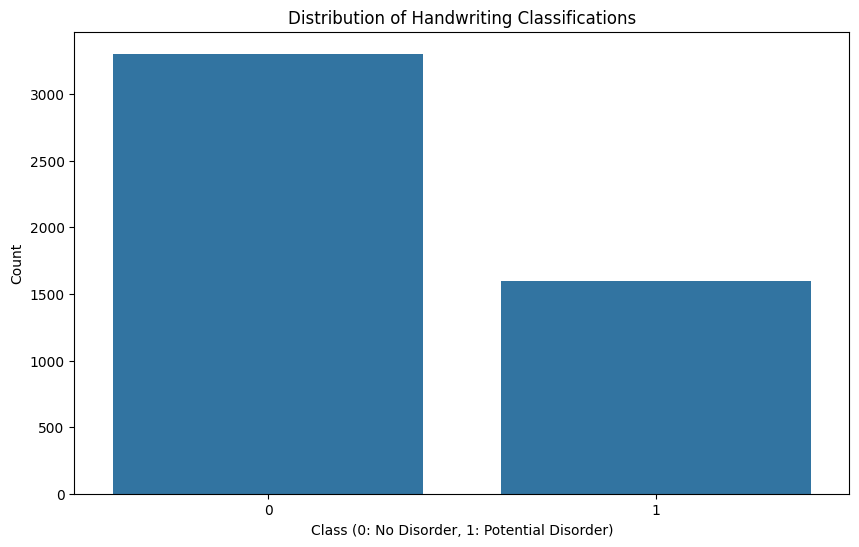

In [14]:
# Visualize Distribution (Same as before)
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.title('Distribution of Handwriting Classifications')
plt.xlabel('Class (0: No Disorder, 1: Potential Disorder)')
plt.ylabel('Count')
plt.show()

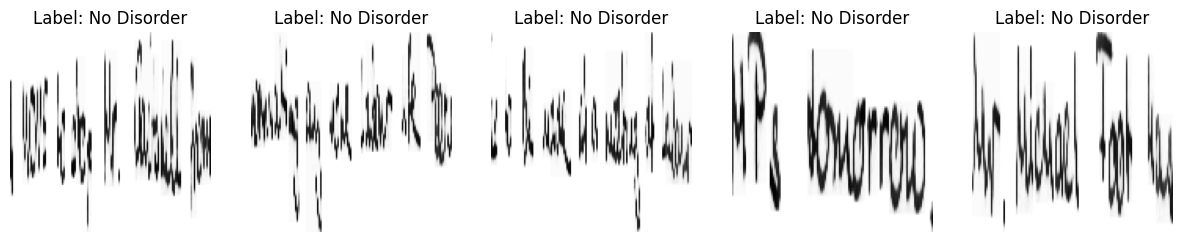

In [15]:
# Display sample images with their classifications
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(features[i].reshape(image_size), cmap='gray')
    plt.title(f'Label: {"Potential" if labels[i] == 1 else "No"} Disorder')
    plt.axis('off')
plt.show()

### **5. Prepare Data**

In [16]:
# Prepare Data for Training
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

### Augmentation

In [17]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

### Build CNN Model

In [18]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


d:\Project\Capstone 2\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,137 (12.46 MB)

 Trainable params: 3,267,137 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


d:\Project\Capstone 2\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.6458 - loss: 0.7324 - val_accuracy: 0.6908 - val_loss: 0.5670
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.6748 - loss: 0.5783 - val_accuracy: 0.7633 - val_loss: 0.4785
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7333 - loss: 0.4984 - val_accuracy: 0.7939 - val_loss: 0.4282
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7558 - loss: 0.4725 - val_accuracy: 0.7959 - val_loss: 0.4389
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7667 - loss: 0.4634 - val_accuracy: 0.6643 - val_loss: 0.5424
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7372 - loss: 0.4790 - val_accuracy: 0.7939 - val_loss: 0.4319
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7729 - loss: 0.4486 - val_accuracy: 0.7929 - val_loss: 0.4232
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7809 - loss: 0.4393 - val_accurac

### **6. Evaluation**

In [21]:
# Evaluate Model Performance
# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       677
           1       0.71      0.80      0.76       303

    accuracy                           0.84       980
   macro avg       0.81      0.83      0.82       980
weighted avg       0.85      0.84      0.84       980



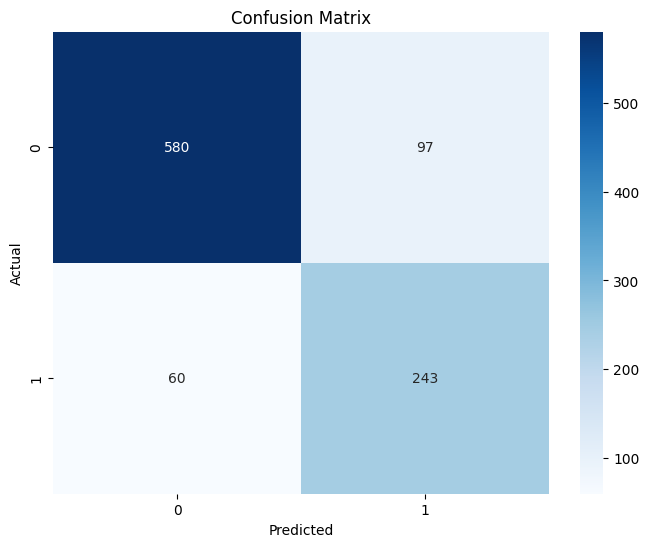

In [22]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

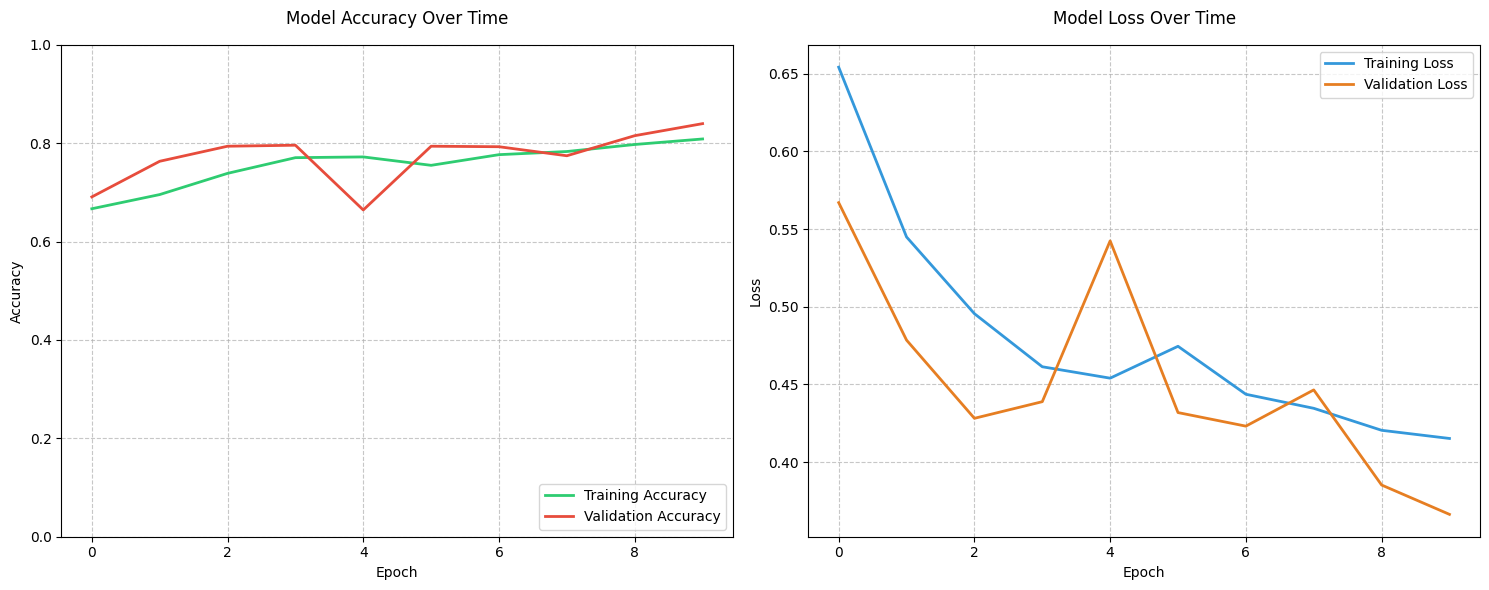

In [25]:
# Visualize Training History with Clear Metrics

# Create figure with larger size and better spacing
plt.figure(figsize=(15, 6))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#e74c3c')
plt.title('Model Accuracy Over Time', fontsize=12, pad=15)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='lower right')
plt.ylim([0, 1])  # Set y-axis from 0 to 1 for accuracy

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#3498db')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e67e22')
plt.title('Model Loss Over Time', fontsize=12, pad=15)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [26]:
# Print actual values for better analysis
print("\nTraining Metrics:")
print("-----------------")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Calculate and print the gap between training and validation metrics
print("\nMetric Gaps:")
print("------------")
acc_gap = abs(history.history['accuracy'][-1] - history.history['val_accuracy'][-1])
loss_gap = abs(history.history['loss'][-1] - history.history['val_loss'][-1])
print(f"Accuracy Gap (Train-Val): {acc_gap:.4f}")
print(f"Loss Gap (Train-Val): {loss_gap:.4f}")


Training Metrics:
-----------------
Final Training Accuracy: 0.8086
Final Validation Accuracy: 0.8398
Final Training Loss: 0.4153
Final Validation Loss: 0.3664

Metric Gaps:
------------
Accuracy Gap (Train-Val): 0.0312
Loss Gap (Train-Val): 0.0488


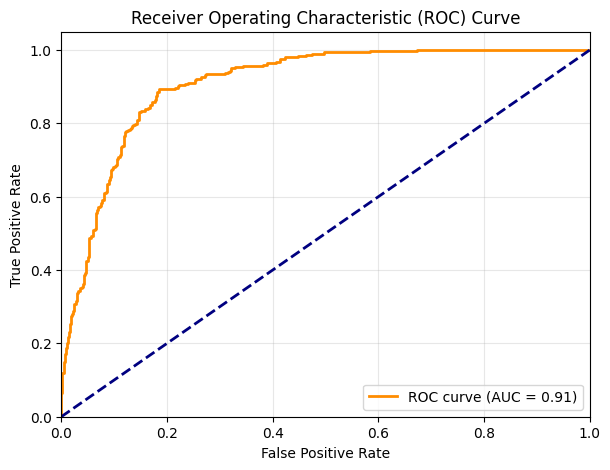

In [33]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

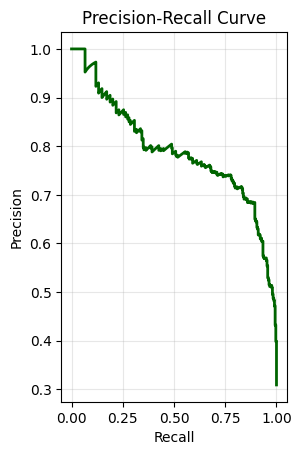

In [34]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkgreen', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# Function to plot prediction examples with fixed confidence formatting
def plot_prediction_examples(X, y_true, y_pred, y_pred_prob, num_examples=8):
    # Find indices for each category
    correct_normal = np.where((y_true == 0) & (y_pred == 0))[0]
    correct_disorder = np.where((y_true == 1) & (y_pred == 1))[0]
    false_positive = np.where((y_true == 0) & (y_pred == 1))[0]
    false_negative = np.where((y_true == 1) & (y_pred == 0))[0]
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    # Plot examples for each category
    for i, (category, title) in enumerate([
        (correct_normal, 'Correct: No Disorder'),
        (correct_disorder, 'Correct: Potential Disorder'),
        (false_positive, 'False Positive'),
        (false_negative, 'False Negative')
    ]):
        if len(category) > 0:
            # Randomly select two examples from each category
            for j in range(2):
                if j < len(category):
                    idx = np.random.choice(category)
                    ax = axes[i * 2 + j]
                    
                    # Display the image
                    ax.imshow(X[idx].reshape(128, 128), cmap='gray')
                    
                    # Prepare labels and confidence
                    true_label = "No Disorder" if y_true[idx] == 0 else "Potential Disorder"
                    pred_label = "No Disorder" if y_pred[idx] == 0 else "Potential Disorder"
                    conf_value = float(y_pred_prob[idx])
                    
                    # Set title color
                    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
                    
                    # Set title with proper confidence formatting
                    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf_value:.3f}', 
                               color=color, fontsize=10)
                    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

C:\Users\madea\AppData\Local\Temp\ipykernel_58424\2743727026.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf_value = float(y_pred_prob[idx])


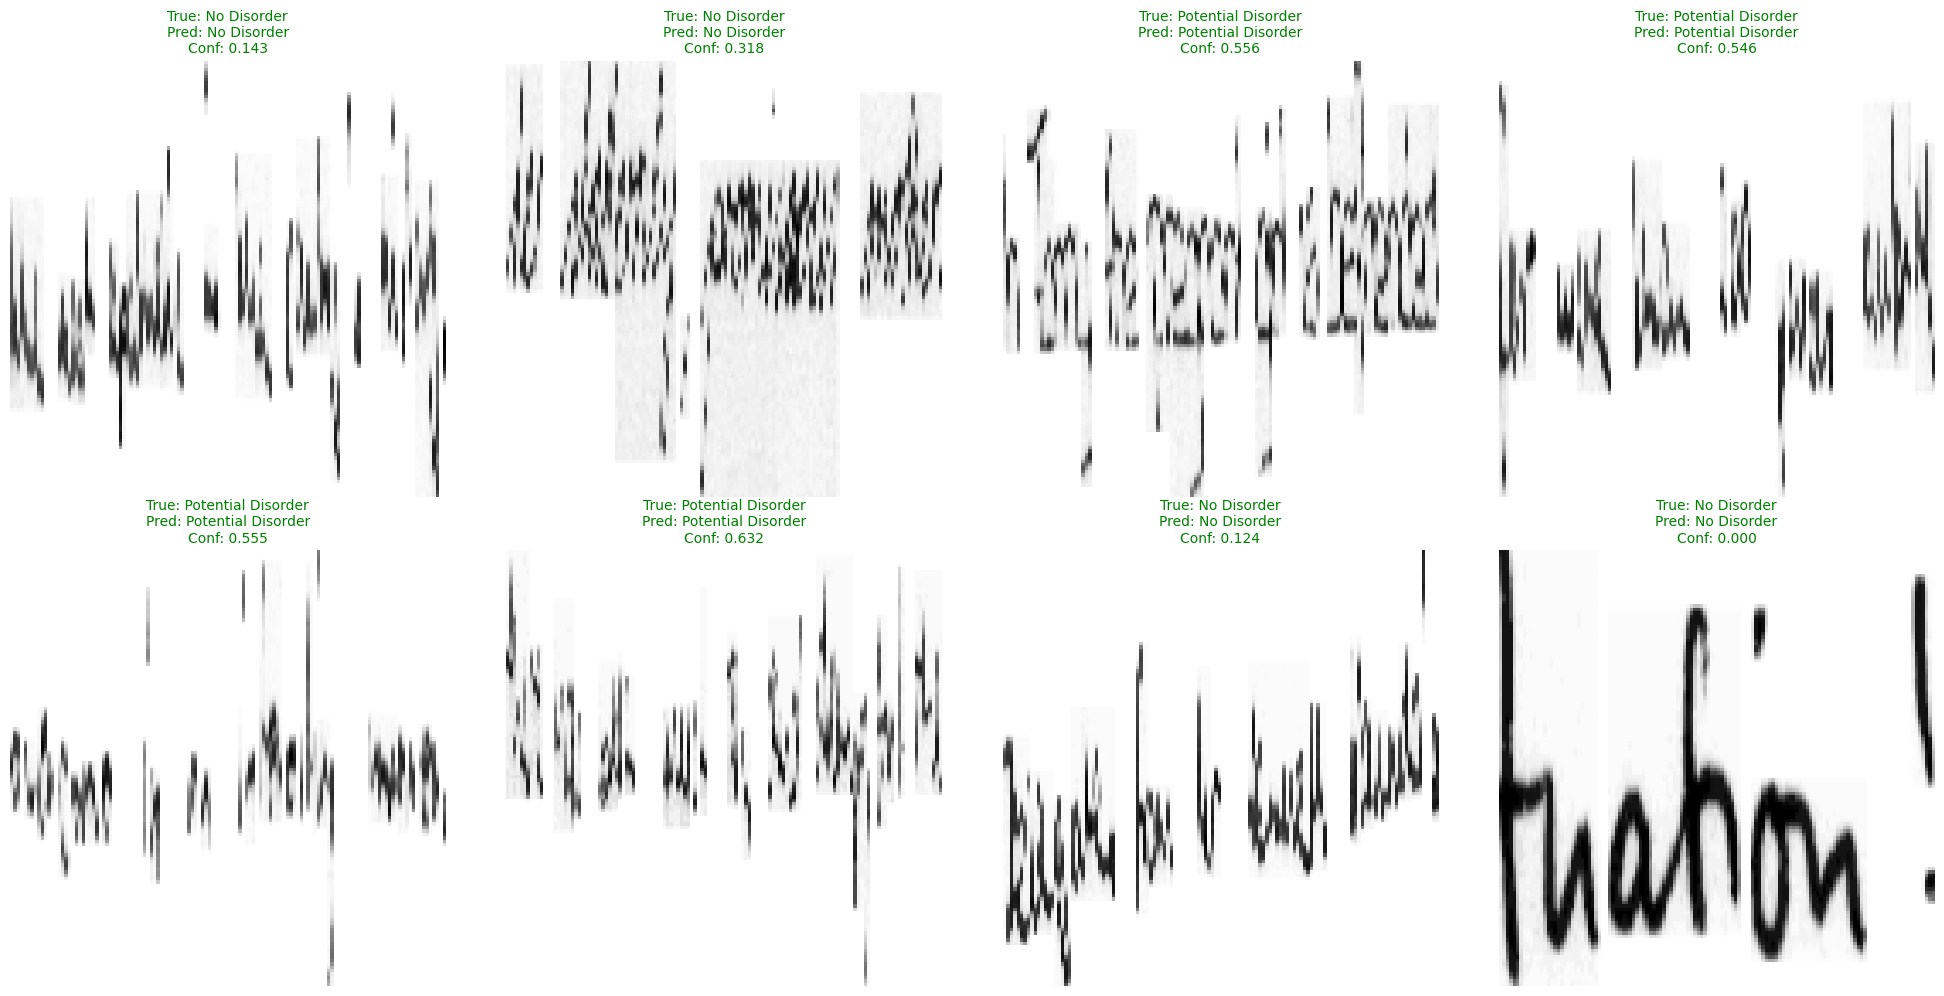

In [38]:
# Plot the examples
plot_prediction_examples(X_test, y_test, y_pred, y_pred_prob)

In [41]:
# Print Detailed Metrics
print("\nDetailed Performance Metrics:")
print("-" * 60)
TP = cm[1,1]  # True Positives
TN = cm[0,0]  # True Negatives
FP = cm[0,1]  # False Positives
FN = cm[1,0]  # False Negatives

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Detailed Performance Metrics:
------------------------------------------------------------
Accuracy: 0.8398
Precision: 0.7147
Recall (Sensitivity): 0.8020
Specificity: 0.8567
F1 Score: 0.7558
ROC AUC Score: 0.9081


### **7. Save Model**

In [68]:
# 1. Save model in .keras format
model.save('./model/mental_health_model.keras')

# 2. Save model in .h5 format
model.save('./model/mental_health_model.h5')

# 3. Save model architecture as JSON
model_json = model.to_json()
with open("./model/mental_health_model.json", "w") as json_file:
    json_file.write(model_json)
# Save weights separately
model.save_weights("./model/mental_health_model.weights.h5")

print("Model saved in multiple formats successfully!")

Model saved in multiple formats successfully!


### **8. Test Model with Unseen Images**

In [113]:
# Function to prepare image
def prepare_image(image_path):
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize to required size
    img = cv2.resize(img, (128, 128))
    # Normalize and add channel dimension
    img = np.expand_dims(img, axis=-1)
    img = img / 255.0
    return img

# Function to predict single image
def predict_image(image_path):
    # Prepare image
    img = prepare_image(image_path)
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    # Make prediction
    prediction = model.predict(img, verbose=0)[0][0]
    # Determine result
    result = "Potential Mental Disorder" if prediction > 0.4 else "No Mental Disorder"
    return result, prediction

# Example usage
image_path = "image5.png"  # Replace with your image path
result, confidence = predict_image(image_path)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2f}")

Prediction: Potential Mental Disorder
Confidence: 0.59


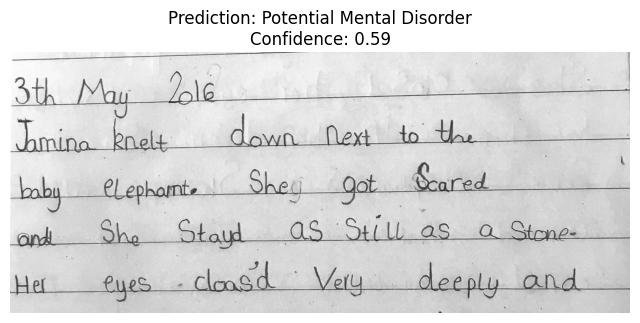

In [114]:
# Optional: Display the image and prediction
import matplotlib.pyplot as plt

def show_prediction(image_path, result, confidence):
    # Read and display image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

# Show the prediction with image
show_prediction(image_path, result, confidence)

Prediction: No Mental Disorder
Confidence: 0.27


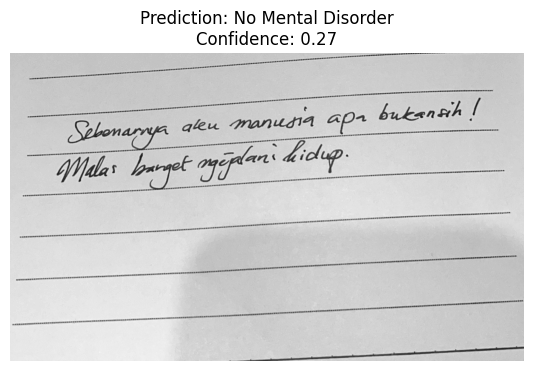

In [107]:
# Example usage
image_path = "image2.jpg"  # Replace with your image path
result, confidence = predict_image(image_path)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2f}")

# Optional: Display the image and prediction
import matplotlib.pyplot as plt

def show_prediction(image_path, result, confidence):
    # Read and display image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

# Show the prediction with image
show_prediction(image_path, result, confidence)

Prediction: Potential Mental Disorder
Confidence: 0.65


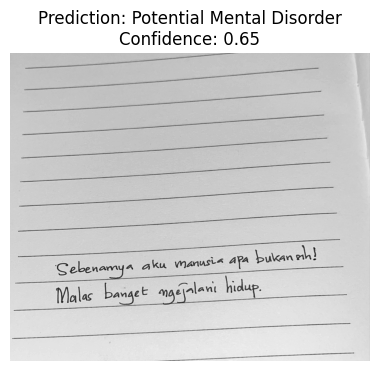

In [108]:
# Example usage
image_path = "image1.jpg"  # Replace with your image path
result, confidence = predict_image(image_path)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2f}")

# Optional: Display the image and prediction
import matplotlib.pyplot as plt

def show_prediction(image_path, result, confidence):
    # Read and display image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

# Show the prediction with image
show_prediction(image_path, result, confidence)

Prediction: No Mental Disorder
Confidence: 0.01


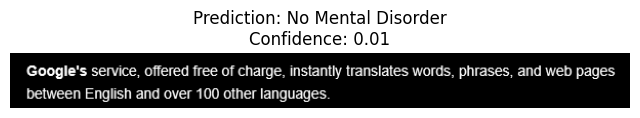

In [109]:
# Example usage
image_path = "image3.png"  # Replace with your image path
result, confidence = predict_image(image_path)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2f}")

# Optional: Display the image and prediction
import matplotlib.pyplot as plt

def show_prediction(image_path, result, confidence):
    # Read and display image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

# Show the prediction with image
show_prediction(image_path, result, confidence)